In [3]:
import glob
import re
from matplotlib.lines import Line2D
import os
from pathlib import Path
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns

In [4]:
def plot_from_saved_1d_projections(npz_files, xhi_marks=(0.5, 0.5, 0.5), xhi_marks_width=(0.1, 0.1, 0.1), save_plot_path=None, 
                                   plot_log=False, ps='PS1'):
    """
    Plots 1D projections from a saved .npz file with vertical lines at specified xHI values.

    Parameters:
        npz_file (str): Path to the .npz file containing the 1D projections
        xhi_marks (tuple): Three xHI values to mark on x, y, z axes respectively
    """
    # Load the saved data
    fig, axes = plt.subplots(1, 3, figsize=(21, 7))


    for i, xhi in enumerate(xhi_marks):
        
        axes[i].axvline(x=xhi_marks[i], color='black', linestyle='--', 
                label=f'Input $x_{{\\mathrm{{HI}}}}$={xhi:.2f}')
        epsilon = xhi_marks_width[i]/2  # Width of the vertical band
        ymin, ymax = axes[i].get_ylim()

        axes[i].fill_betweenx(
            [ymin, ymax],                     # y-range (bottom to top)
            xhi_marks[i] - epsilon,          # left edge of band
            xhi_marks[i] + epsilon,          # right edge of band
            color='black',
            alpha=0.3,                        # transparency
            #label=f'Input $x_{{\\mathrm{{HI}}}}$={xhi:.2f}'
        )
        axes[i].legend(fontsize=15)
    #axes[0].legend(fontsize=15)
    #axes[1].legend(fontsize=15)
    axes[2].legend(fontsize=15)

    #linestyles = ['-', '-.', '--',  ':', 'dotted']
    linestyles = [
    '-',        # solid
    '--',       # dashed
    '-.',       # dash-dot
    ':',        # dotted
    (0, (3, 1)),           # short dash
    (0, (5, 2)),           # medium dash
    (0, (3, 5, 1, 5)),     # dash-dot pattern

    ]

    # Use 'tab20' colormap (20 unique colors)
    cmap = get_cmap('tab20')
    colors = [cmap(i % 20) for i in range(len(npz_files))]  # Will cycle if >20
    #colors = sns.color_palette("Paired", 12) + sns.color_palette("Set3", 12)

    colors = sns.color_palette("tab20", 20) + sns.color_palette("Set3", 10)
    linestyles = ['-', '--', '-.', ':', (0, (3, 1)), (0, (5, 2))]
    #markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'X']

    combined_styles = []
    for i in range(29):
        style = {
            'color': colors[i % len(colors)],
            'linestyle': linestyles[i % len(linestyles)],
            #'marker': markers[i % len(markers)],
        }
        combined_styles.append(style)

    
    
    team_handles = []
    team_labels = []

    for i, npz_file in enumerate(npz_files):  
        data = np.load(npz_file)
        base_name = os.path.splitext(os.path.basename(npz_file))[0]
        base_name = base_name.replace('_PS1_1D_projections', ' ').strip()  # Remove the suffix
        base_name = base_name.replace('_PS2_1D_projections', ' ').strip()  # Remove the suffix


        if base_name == 'ToSKA-SBI_focused':
            base_name = 'ToSKA-model_selection'
        else:
            None
        

        # Define the plotting parameters
        if base_name in ['LoreliB', 'EoR-PIE-MC', 'EoR-PIE']:
            projections = [data['proj_z'], data['proj_y'], data['proj_x']]
            coordinates = [data['z_values'], data['y_values'], data['x_values']]
            labels = data['axis_labels']
            labels[0], labels[2] = labels[2], labels[0]

            titles = ['Projection along z', 'Projection along y', 'Projection along x']
        else:
            projections = [data['proj_x'], data['proj_y'], data['proj_z']]
            coordinates = [data['x_values'], data['y_values'], data['z_values']]
            labels = data['axis_labels']
            titles = ['Projection along x', 'Projection along y', 'Projection along z']


        for ax, proj, coords, label, title, xhi in zip(axes, projections, coordinates, labels, titles, xhi_marks):
            # Plot the 1D projection
            style = combined_styles[i]
            if plot_log:
                line, = ax.plot(coords, np.log10(proj), linewidth=4, label= base_name, markevery=1, **style)
                                #color=colors[i], ls = linestyles[i % len(linestyles)])
                ax.set_ylim(-5, 0.0)
                ax.set_ylabel('log Marginalized Posterior', fontsize=20)


            else:
                line, = ax.plot(coords, proj, linewidth=3, label= base_name, markevery=1, markersize=10, **style) 
                                #color=colors[i], ls = linestyles[i % len(linestyles)])
                #ax.set_ylim(0.0, 0.85)
                ax.set_ylim(0.0, 0.6)

                ax.set_ylabel('Marginalized Posterior', fontsize=20)


        
            # Add vertical line at xHI value
            
            ax.set_xlabel(label, fontsize=20)
            ax.grid(False)
        
            # Set x-axis limits and ticks

            if ps == 'PS1': 
                ax.set_xlim(0.05, 1.05)
                ax.set_xticks(np.linspace(0, 1, 6))
            elif ps == 'PS2':
                ax.set_xlim(0.4, 1.05)
                ax.set_xticks(np.linspace(0.4, 1, 6))

            
            
            
            #ax.set_ylim(0.0, 1.05)

            
            ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
        
            # Add legend
            #ax.legend(fontsize=15)
        # Store one handle per team (avoid duplication from each subplot)
        team_handles.append(line)
        team_labels.append(base_name)        
        
    

    #axes[2].legend(bbox_to_anchor=(0., 1.05),fontsize=15,ncol=4)
        
    #plt.tight_layout()
    #plt.tight_layout(rect=[0, 0.05, 1.5, 1.5])  # leave space at bottom for legend
    if plot_log:
        save_plot_path.replace('.jpg', '_log.jpg')
    else:
        None
    plt.legend(
        team_handles, team_labels,
        loc='lower center',           # Place it at the bottom center
        bbox_to_anchor=(-0.1, -0.65),  # Adjust vertical position; tweak as needed
        ncol=4,                       # Number of columns in legend
        fontsize=15,                  # Font size
        frameon=False,                # Optional: removes the box around legend
    )
    plt.savefig(save_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()

/var/folders/r3/wkx5crls3r79zq7hshdwglzx0gkbmn/T/ipykernel_77140/3303854303.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


IndexError: list index out of range

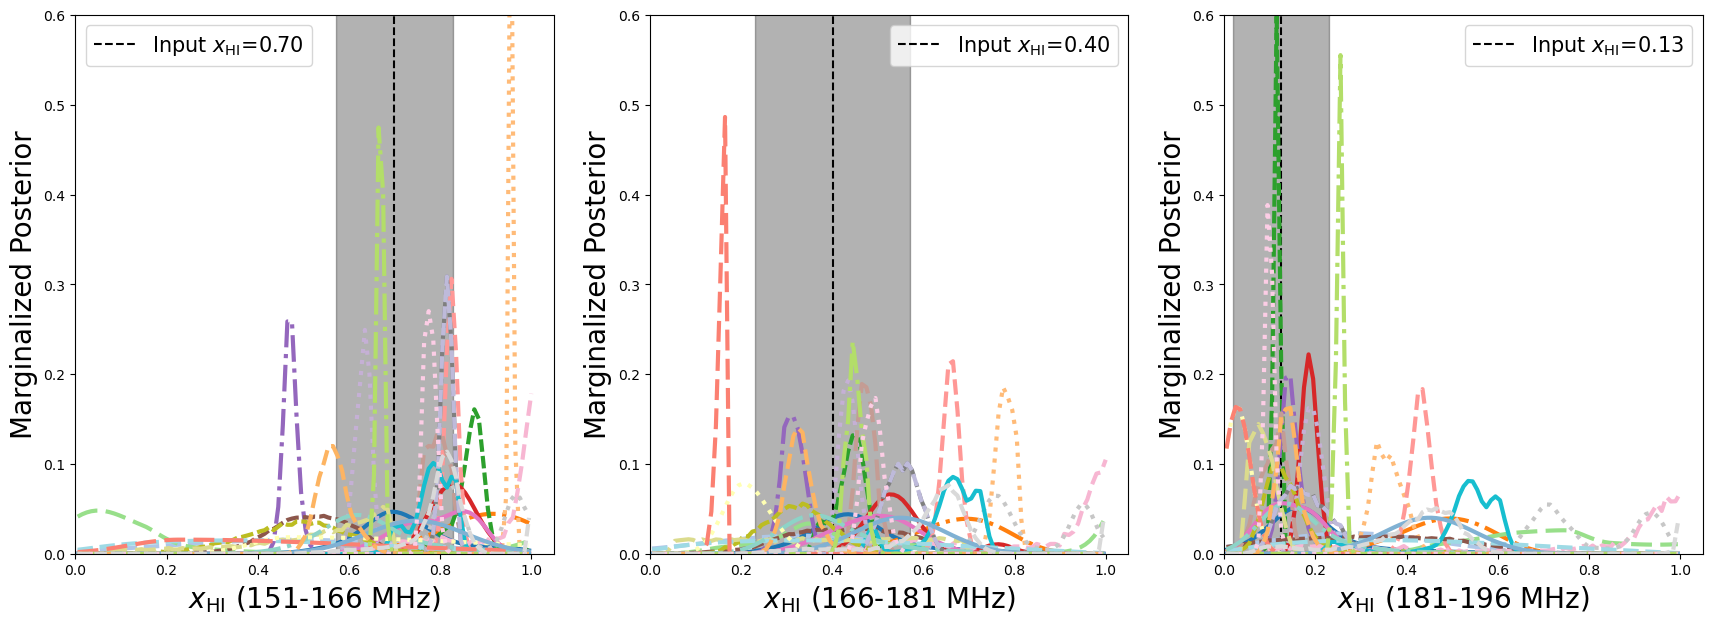

In [5]:

submissions_dir='/Users/omkar.bait/work/SDC/sdc3b/submission_analysis/submissions_processed'
ps1_npz_files = glob.glob(submissions_dir+ '/*_PS1_1D_projections.npz')


plot_dir = submissions_dir + '/plots/'
#print(ps1_npz_files)

#for npz in ps1_npz_files[0:2]:
    #print(npz)
plot_from_saved_1d_projections(ps1_npz_files[0:], xhi_marks=(0.699600, 0.401250, 0.125250), xhi_marks_width=(0.2558,0.3409,0.2111), 
                               save_plot_path=plot_dir+'1D_proj_allteams_PS1.jpg', 
                               plot_log=False)


/var/folders/r3/wkx5crls3r79zq7hshdwglzx0gkbmn/T/ipykernel_77140/3303854303.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


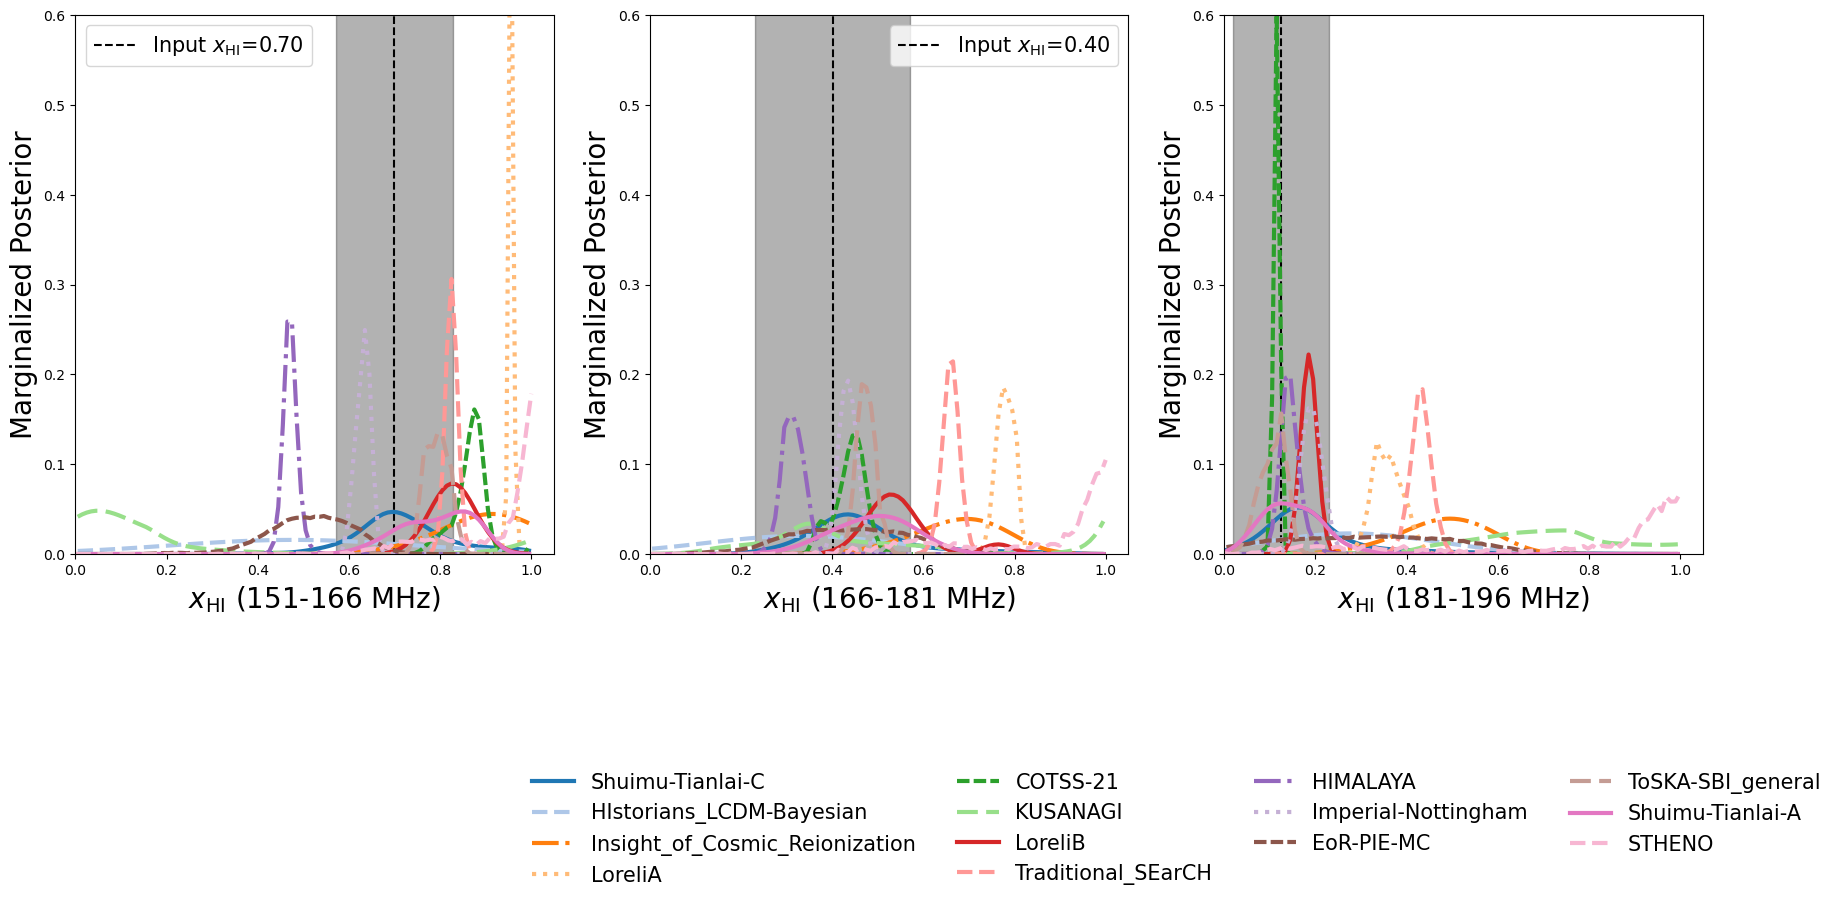

<Figure size 640x480 with 0 Axes>

In [7]:
plot_from_saved_1d_projections(ps1_npz_files[0:14], xhi_marks=(0.699600, 0.401250, 0.125250), xhi_marks_width=(0.2558,0.3409,0.2111),
                               save_plot_path=plot_dir+'1D_proj_PS1_part1.jpg')


/var/folders/r3/wkx5crls3r79zq7hshdwglzx0gkbmn/T/ipykernel_77140/3303854303.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


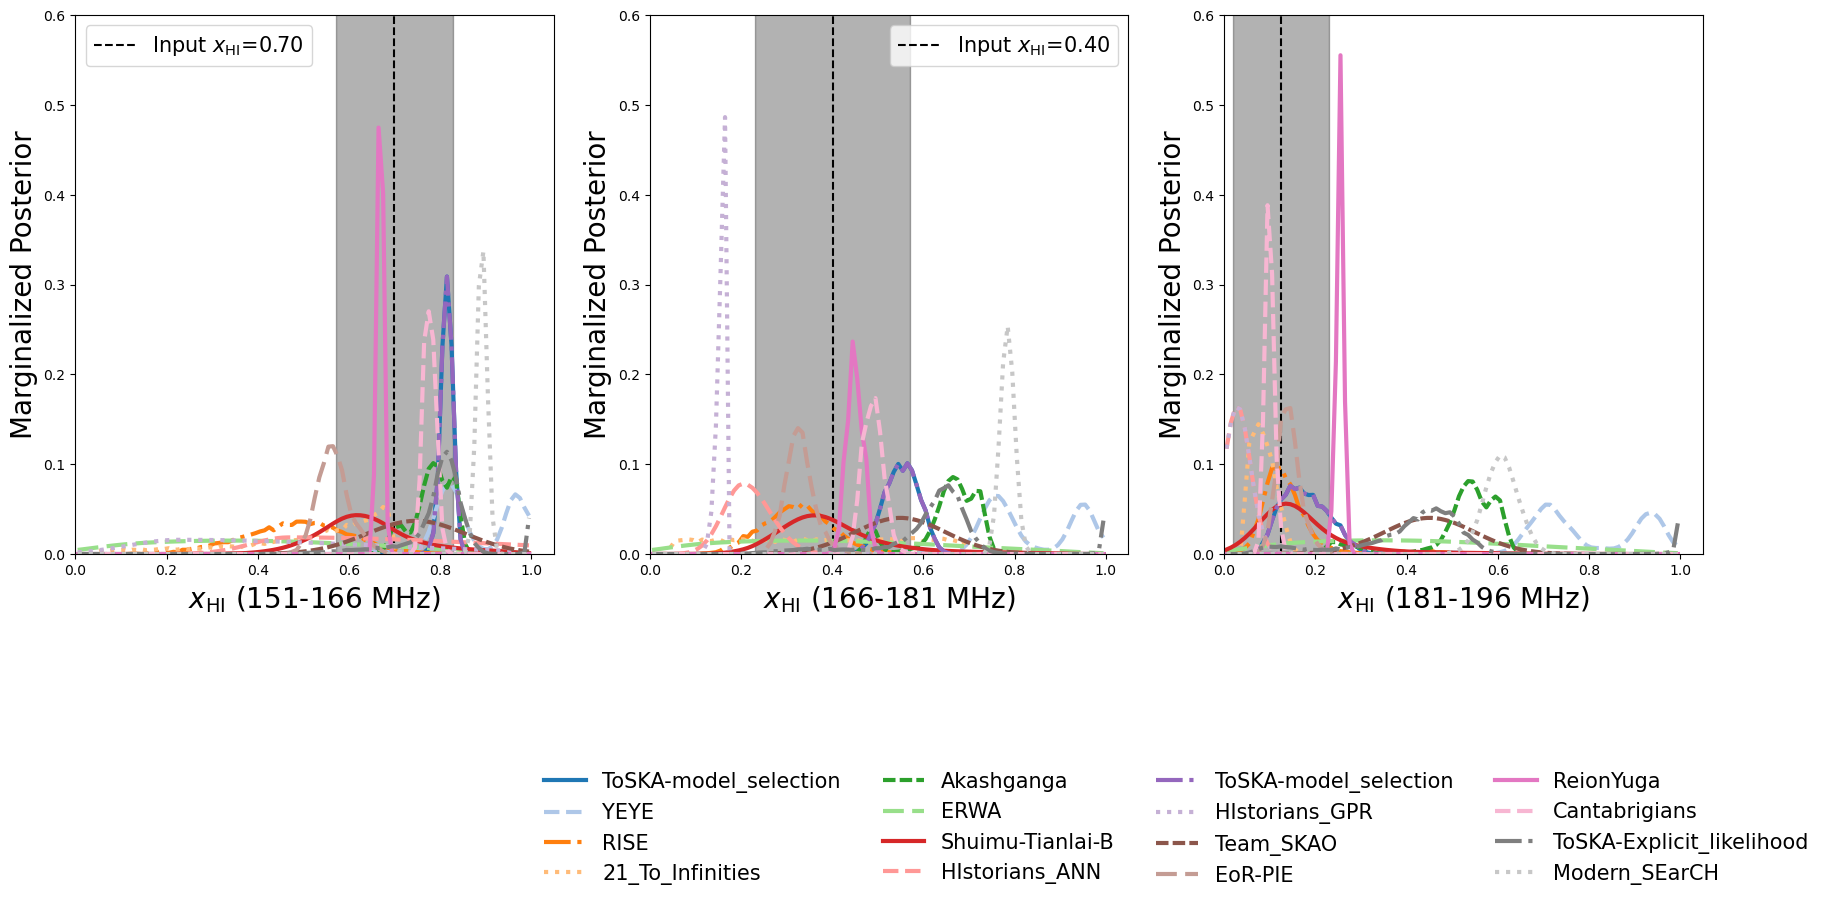

<Figure size 640x480 with 0 Axes>

In [8]:
plot_from_saved_1d_projections(ps1_npz_files[14:], xhi_marks=(0.699600, 0.401250, 0.125250), xhi_marks_width=(0.2558,0.3409,0.2111),
                               save_plot_path=plot_dir+'1D_proj_PS1_part2.jpg')

/var/folders/r3/wkx5crls3r79zq7hshdwglzx0gkbmn/T/ipykernel_77140/3303854303.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


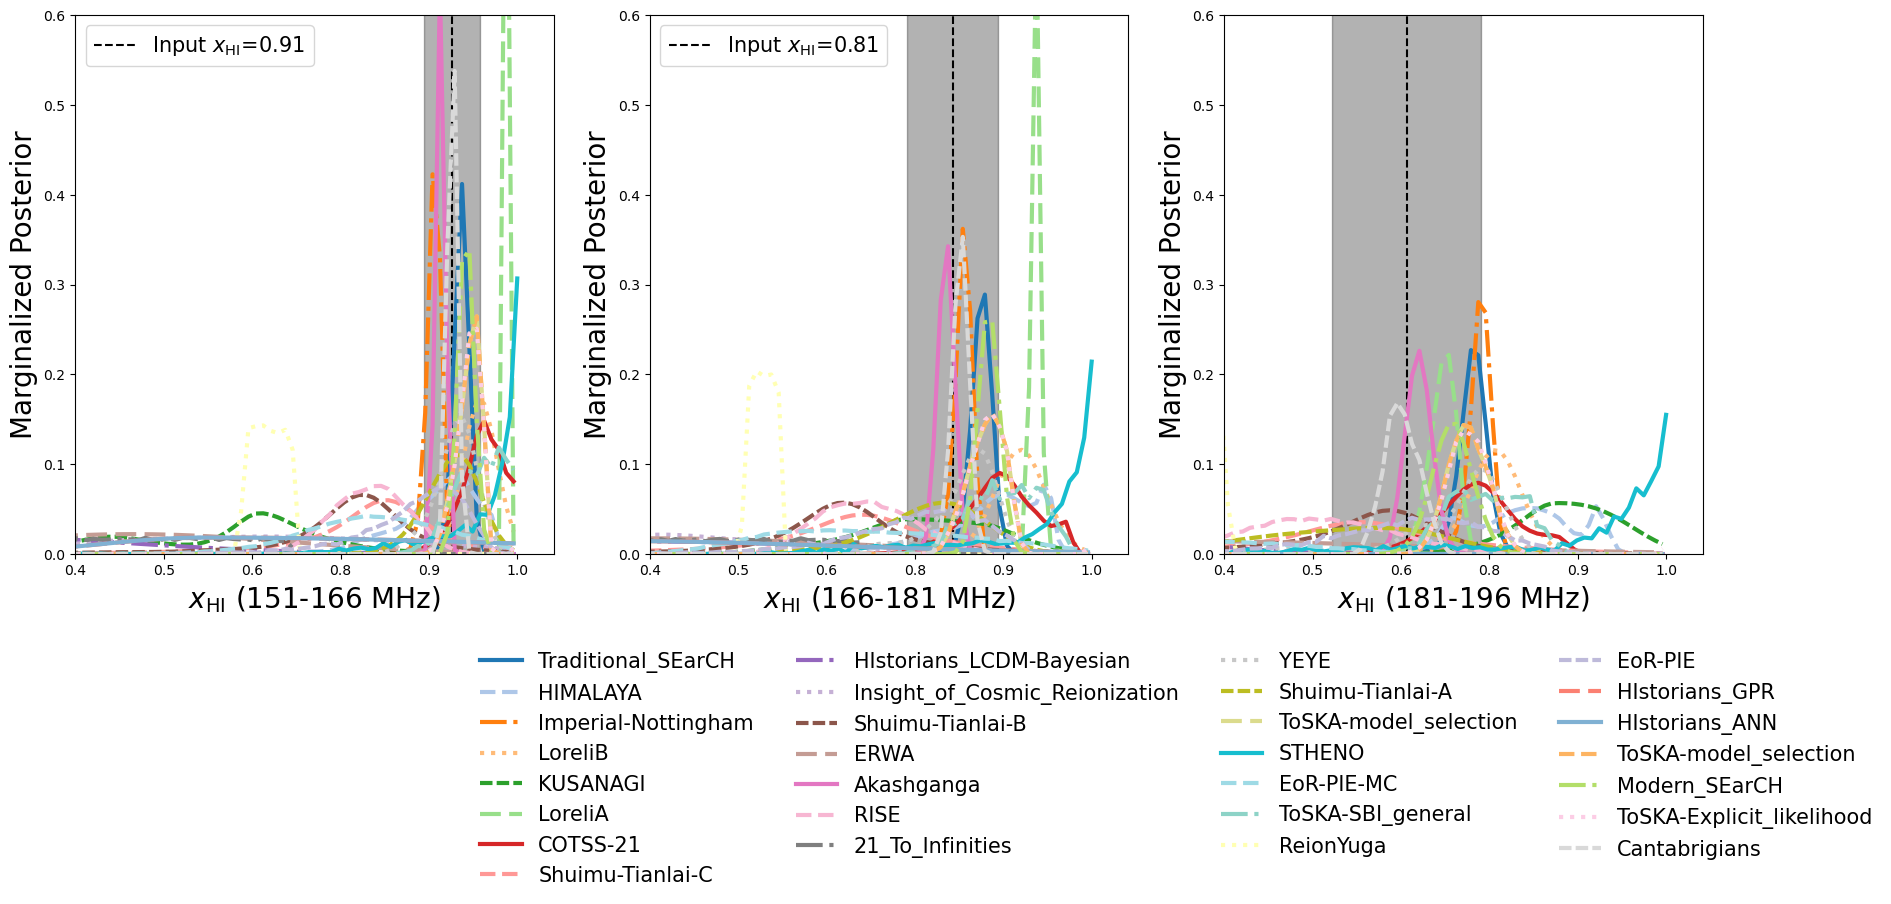

<Figure size 640x480 with 0 Axes>

In [9]:

submissions_dir='/Users/omkar.bait/work/SDC/sdc3b/submission_analysis/submissions_processed'
ps2_npz_files = glob.glob(submissions_dir+ '/*_PS2_1D_projections.npz')


   


plot_dir = submissions_dir + '/plots/'
#print(ps1_npz_files)

#for npz in ps1_npz_files[0:2]:
    #print(npz)
plot_from_saved_1d_projections(ps2_npz_files[0:], xhi_marks=(0.911173, 0.811154, 0.647652), xhi_marks_width=(0.0763450, 0.123693, 0.20331),
                               save_plot_path=plot_dir+'1D_proj_allteams_PS2.jpg', 
                               plot_log=False, ps = 'PS2')




/var/folders/r3/wkx5crls3r79zq7hshdwglzx0gkbmn/T/ipykernel_77140/3303854303.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


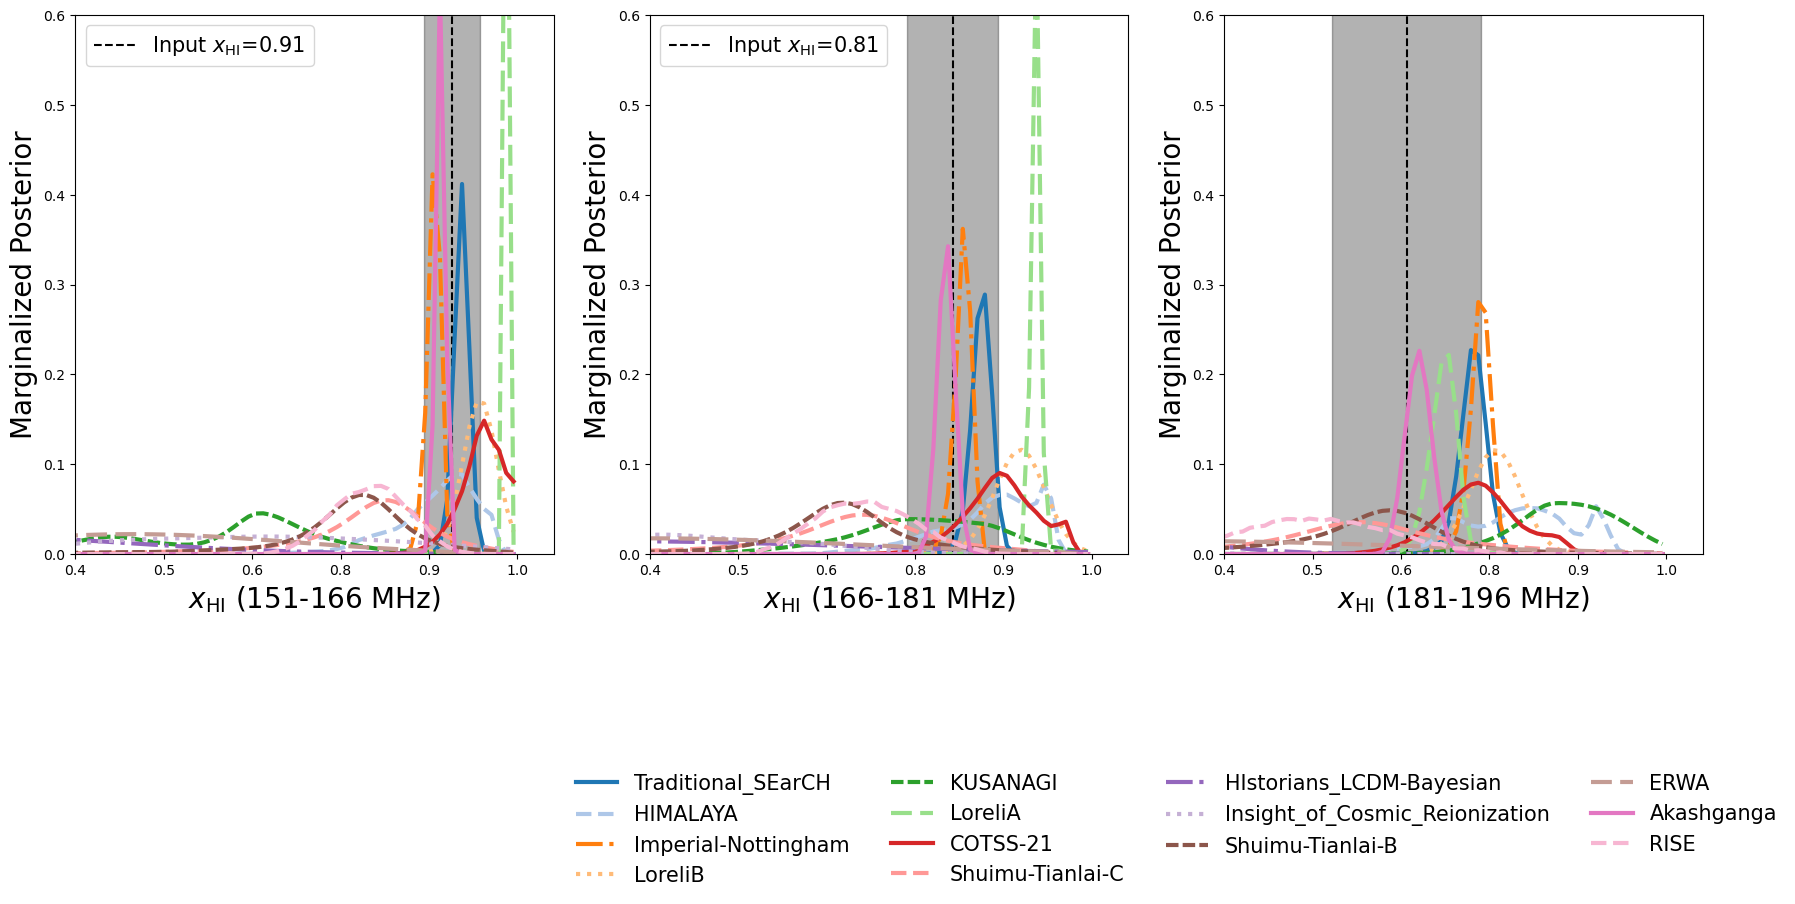

/var/folders/r3/wkx5crls3r79zq7hshdwglzx0gkbmn/T/ipykernel_77140/3303854303.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


<Figure size 640x480 with 0 Axes>

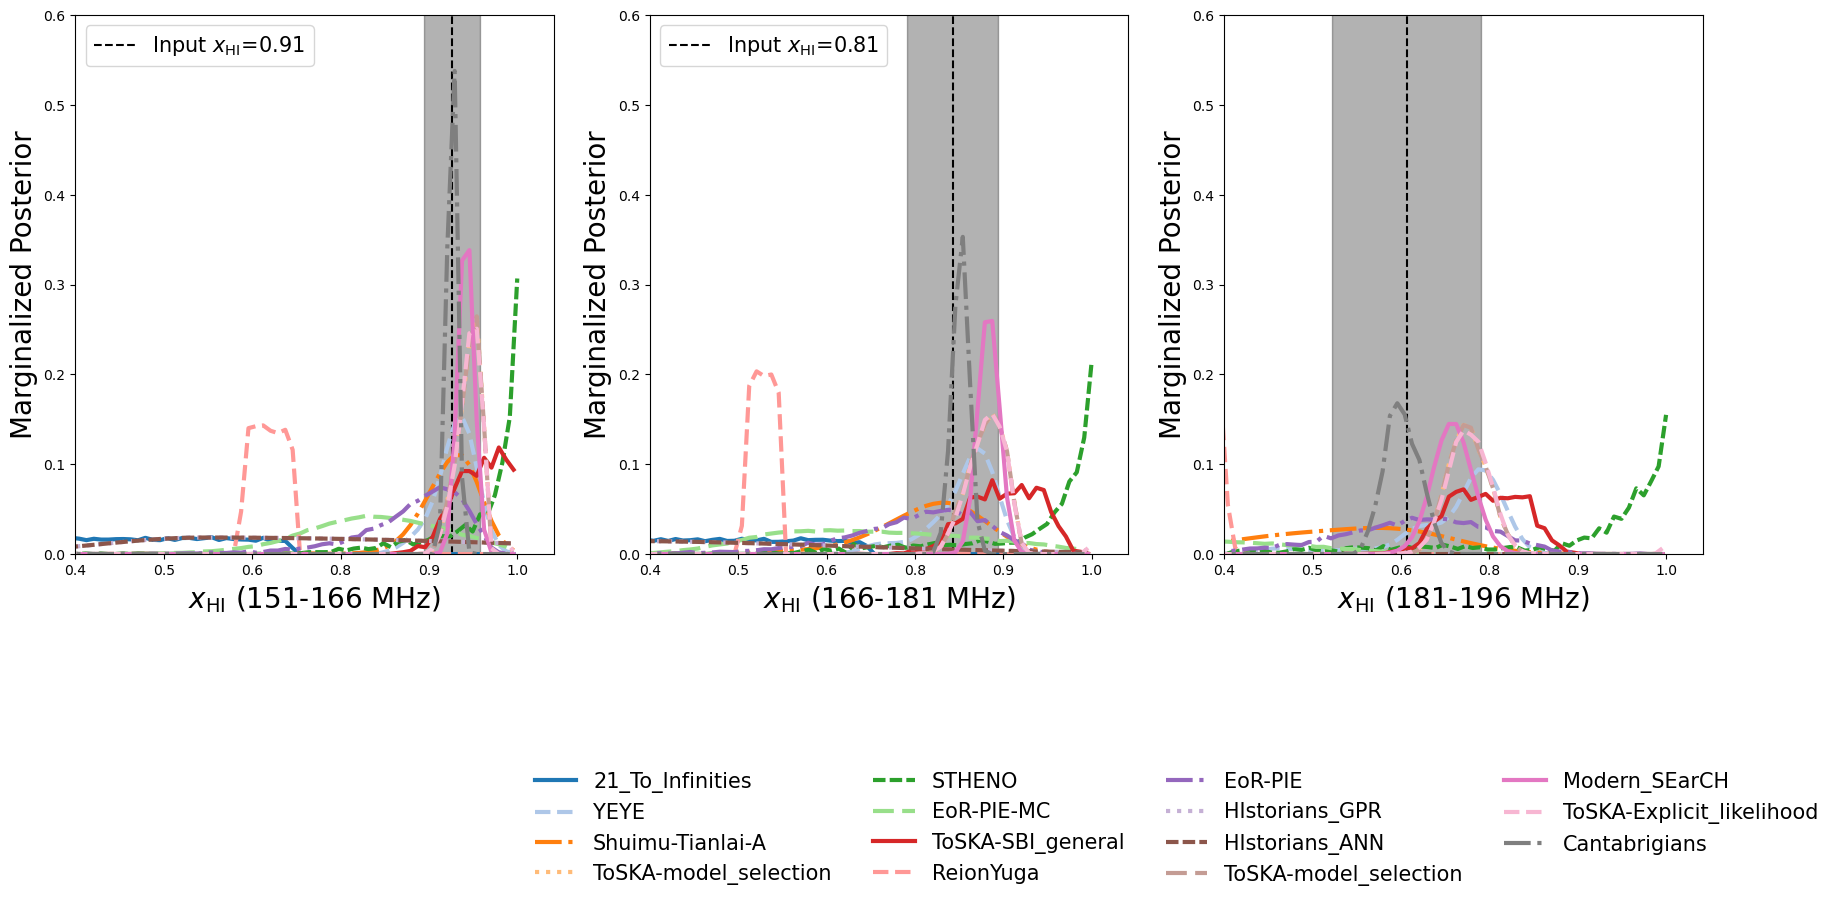

<Figure size 640x480 with 0 Axes>

In [10]:
plot_from_saved_1d_projections(ps2_npz_files[0:14], xhi_marks=(0.911173, 0.811154, 0.647652), xhi_marks_width=(0.0763450, 0.123693, 0.20331),
                               save_plot_path=plot_dir+'1D_proj_PS2_part1.jpg', ps= 'PS2')


plot_from_saved_1d_projections(ps2_npz_files[14:], xhi_marks=(0.911173, 0.811154, 0.647652), xhi_marks_width=(0.0763450, 0.123693, 0.20331),
                               save_plot_path=plot_dir+'1D_proj_PS2_part2.jpg', ps= 'PS2')

/var/folders/r3/wkx5crls3r79zq7hshdwglzx0gkbmn/T/ipykernel_77140/3303854303.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


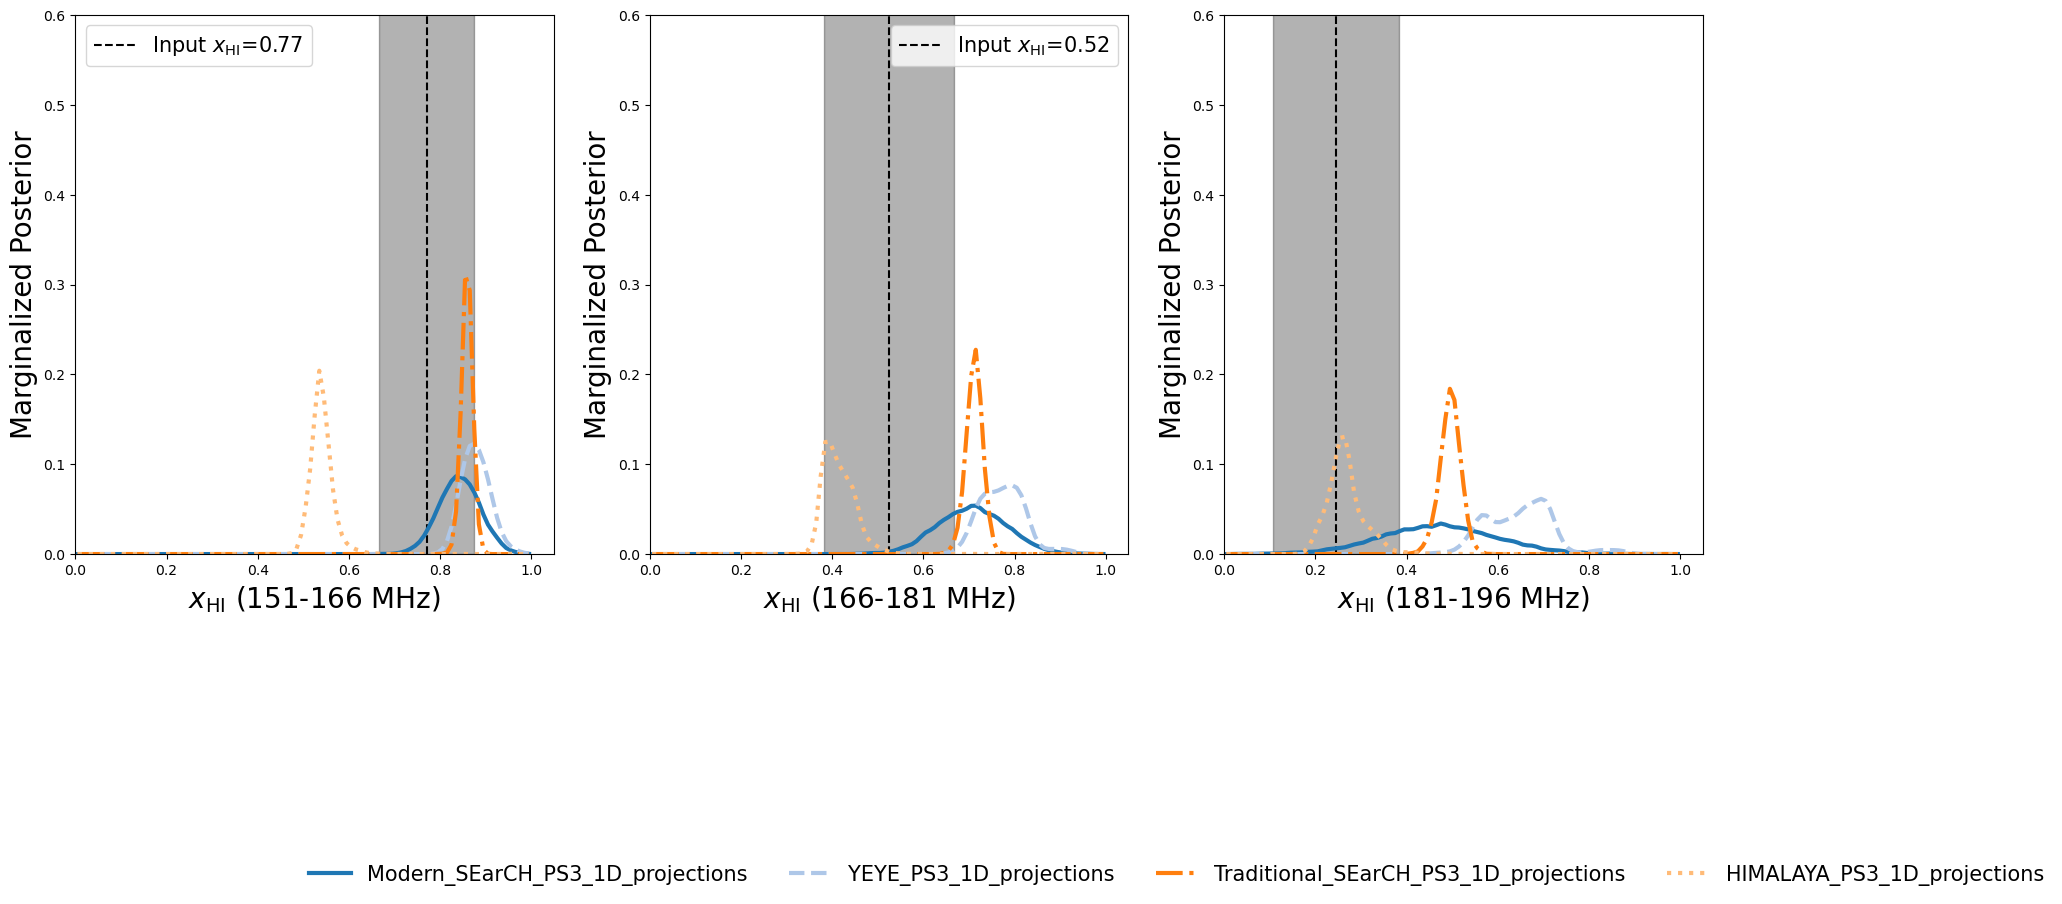

<Figure size 640x480 with 0 Axes>

In [6]:
import glob
submissions_dir='/Users/omkar.bait/work/SDC/sdc3b/submission_analysis/submissions_processed'
ps3_npz_files = glob.glob(submissions_dir+ '/*_PS3_1D_projections.npz')


plot_dir = submissions_dir + '/plots/'
#print(ps1_npz_files)

#for npz in ps1_npz_files[0:2]:
    #print(npz)
plot_from_saved_1d_projections(ps3_npz_files[0:], xhi_marks=(0.770638, 0.524308, 0.244184), xhi_marks_width=(0.208909, 0.283752, 0.276496), 
                               save_plot_path=plot_dir+'1D_proj_allteams_PS3.jpg', 
                               plot_log=False)


/var/folders/r3/wkx5crls3r79zq7hshdwglzx0gkbmn/T/ipykernel_77140/3303854303.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')


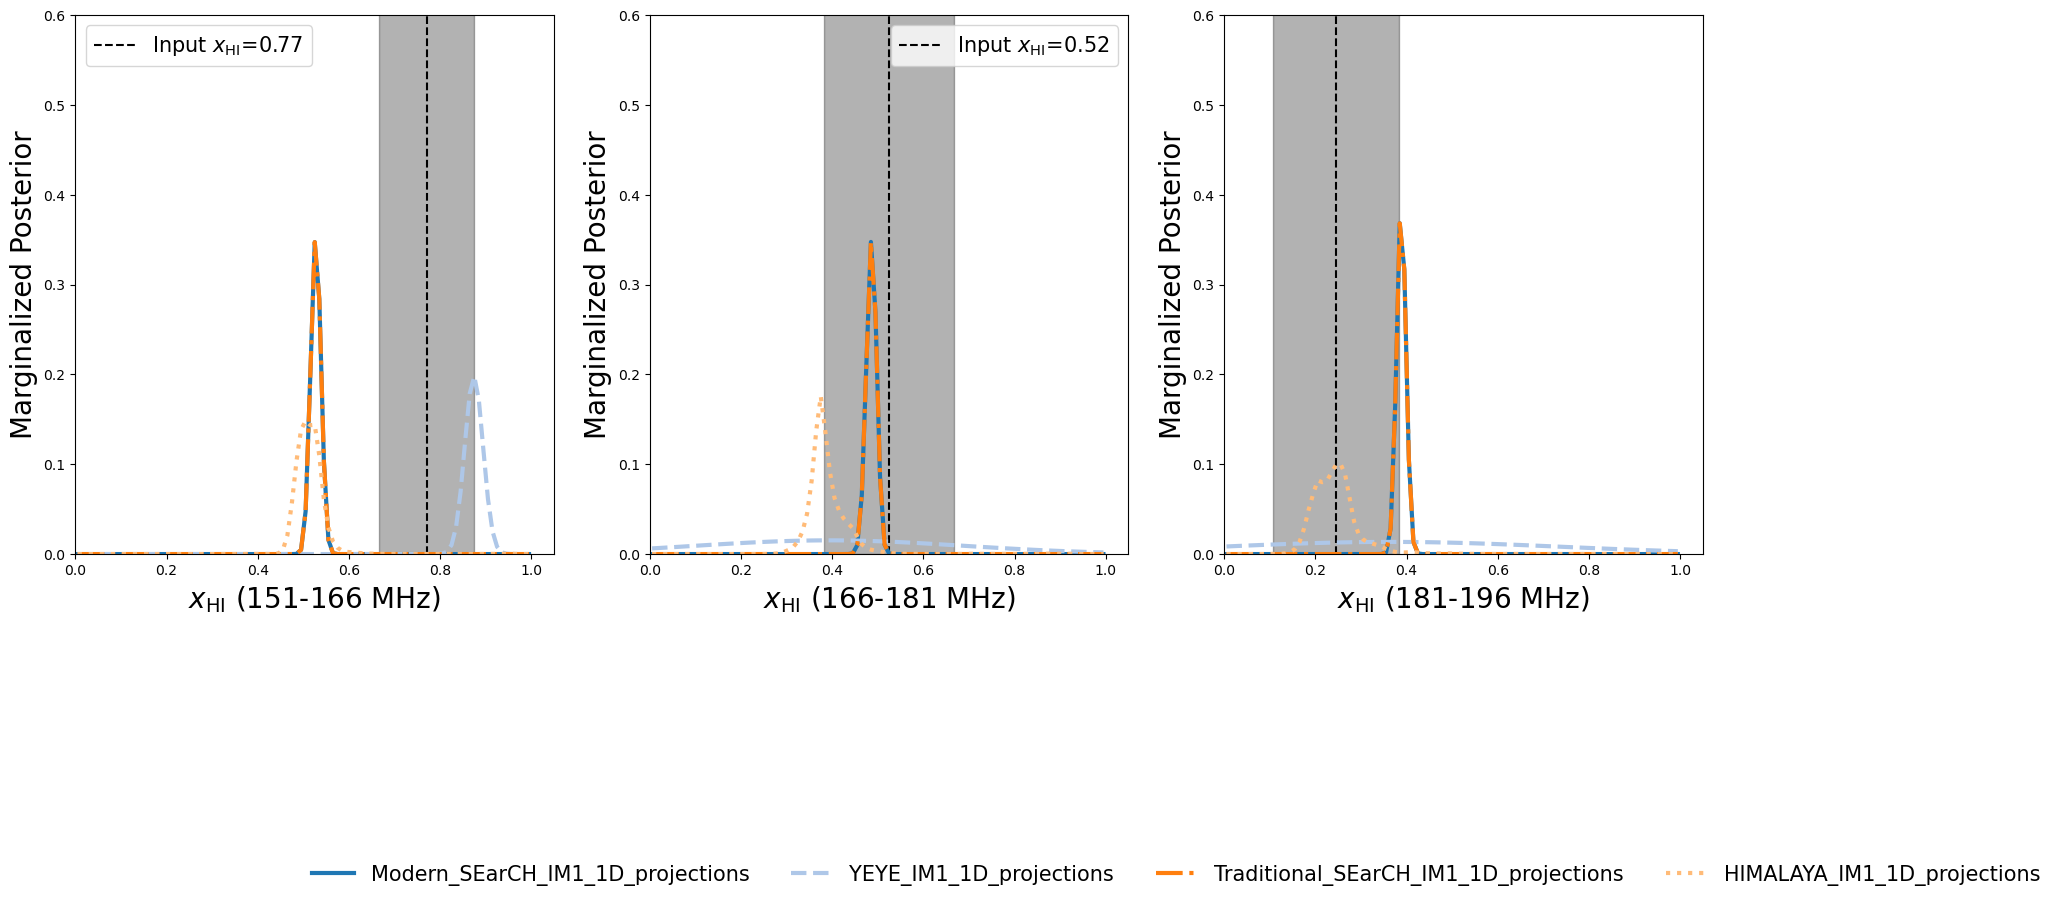

<Figure size 640x480 with 0 Axes>

In [11]:
submissions_dir='/Users/omkar.bait/work/SDC/sdc3b/submission_analysis/submissions_processed'
im1_npz_files = glob.glob(submissions_dir+ '/*_IM1_1D_projections.npz')


plot_dir = submissions_dir + '/plots/'
#print(ps1_npz_files)

#for npz in ps1_npz_files[0:2]:
    #print(npz)
plot_from_saved_1d_projections(im1_npz_files[0:], xhi_marks=(0.770638, 0.524308, 0.244184), xhi_marks_width=(0.208909, 0.283752, 0.276496), 
                               save_plot_path=plot_dir+'1D_proj_allteams_IM1.jpg', 
                               plot_log=False)


In [138]:
import numpy as np
import os

def find_xhi_at_pdf_peaks(npz_files):
    """
    Reads 1D projection data from .npz files and finds the xHI values at which each
    of the x/y/z projections peaks (i.e., maximum posterior value).

    Parameters:
        npz_files (list): List of paths to .npz files.

    Returns:
        dict: Dictionary with keys as filenames and values as (xHI_x, xHI_y, xHI_z) at PDF peaks.
    """
    xhi_peaks = {}

    for npz_file in npz_files:
        data = np.load(npz_file)
        base_name = os.path.splitext(os.path.basename(npz_file))[0]
        base_name = base_name.replace('_PS1_1D_projections', ' ').strip()

        projections = [data['proj_x'], data['proj_y'], data['proj_z']]
        coordinates = [data['x_values'], data['y_values'], data['z_values']]

        xhi_at_peaks = []

        for coords, proj in zip(coordinates, projections):
            max_idx = np.argmax(proj)
            xhi_peak = coords[max_idx]
            xhi_at_peaks.append(xhi_peak)

        xhi_peaks[base_name] = tuple(xhi_at_peaks)

    return xhi_peaks


In [124]:
#npz_files = ['team1_PS1_1D_projections.npz', 'team2_PS1_1D_projections.npz']
ps1_npz_files = glob.glob(submissions_dir+ '/*_PS1_1D_projections.npz')


peak_xhis = find_xhi_at_pdf_peaks(ps1_npz_files)

for team, xhis in peak_xhis.items():
    print(f"{team}: xHI peaks at x/y/z = {xhis}")

Shuimu-Tianlai-C: xHI peaks at x/y/z = (0.6950000000000001, 0.435, 0.165)
HIstorians_LCDM-Bayesian: xHI peaks at x/y/z = (0.47500000000000003, 0.335, 0.275)
Insight_of_Cosmic_Reionization: xHI peaks at x/y/z = (0.915, 0.6950000000000001, 0.495)
LoreliA: xHI peaks at x/y/z = (0.9550000000000001, 0.775, 0.335)
COTSS-21: xHI peaks at x/y/z = (0.875, 0.455, 0.115)
KUSANAGI: xHI peaks at x/y/z = (0.055, 0.995, 0.745)
LoreliB: xHI peaks at x/y/z = (0.185, 0.525, 0.8250000000000001)
Traditional_SEarCH: xHI peaks at x/y/z = (0.8250000000000001, 0.665, 0.435)
HIMALAYA: xHI peaks at x/y/z = (0.47500000000000003, 0.305, 0.14500000000000002)
Imperial-Nottingham: xHI peaks at x/y/z = (0.635, 0.435, 0.185)
EoR-PIE-MC: xHI peaks at x/y/z = (0.34500000000000003, 0.47500000000000003, 0.545)
ToSKA-SBI_general: xHI peaks at x/y/z = (0.795, 0.465, 0.125)
Shuimu-Tianlai-A: xHI peaks at x/y/z = (0.845, 0.505, 0.125)
STHENO: xHI peaks at x/y/z = (1.0, 1.0, 1.0)
ToSKA-SBI_focused: xHI peaks at x/y/z = (0.8150

In [125]:
import numpy as np
import os

def find_xhi_peaks_and_sorting(npz_files):
    """
    Finds xHI values at which each of the x/y/z projections peaks and classifies teams.

    Parameters:
        npz_files (list): List of paths to .npz files.

    Returns:
        xhi_dict (dict): team_name -> (xHI_x, xHI_y, xHI_z)
        strictly_increasing (list): x < y < z
        non_decreasing (list): x <= y <= z
        increase_then_decrease (list): x < y > z
        strictly_decreasing (list): x > y > z
    """
    xhi_dict = {}
    strictly_increasing = []
    non_decreasing = []
    increase_then_decrease = []
    strictly_decreasing = []

    for npz_file in npz_files:
        data = np.load(npz_file)
        base_name = os.path.splitext(os.path.basename(npz_file))[0]
        team_name = base_name.replace('_PS1_1D_projections', ' ').strip()
        
        if team_name in ['LoreliB', 'EoR-PIE-MC', 'EoR-PIE']:
            print('LoreliB')
            projections = [data['proj_z'], data['proj_y'], data['proj_x']]
            
            coordinates = [data['z_values'], data['y_values'], data['x_values']]

        else:
            projections = [data['proj_x'], data['proj_y'], data['proj_z']]
            
            coordinates = [data['x_values'], data['y_values'], data['z_values']]


        peaks = []
        for coords, proj in zip(coordinates, projections):
            idx = np.argmax(proj)
            peaks.append(coords[idx])

        xhi_dict[team_name] = tuple(peaks)

        x, y, z = peaks

        if x < y < z:
            strictly_increasing.append(team_name)
        if x <= y <= z:
            non_decreasing.append(team_name)
        if x < y > z:
            increase_then_decrease.append(team_name)
        if x > y > z:
            strictly_decreasing.append(team_name)

    return xhi_dict, strictly_increasing, non_decreasing, increase_then_decrease, strictly_decreasing


In [126]:
#npz_files = ['team1_PS1_1D_projections.npz', 'team2_PS1_1D_projections.npz']

xhi_dict, inc, non_dec, inc_dec, dec = find_xhi_peaks_and_sorting(ps1_npz_files)

print("xHI peak values per team:")
for team, xhis in xhi_dict.items():
    print(f"  {team}: xHI_x={xhis[0]:.3f}, xHI_y={xhis[1]:.3f}, xHI_z={xhis[2]:.3f}")

print("\n✅ Strictly Increasing (x < y < z):")
print(inc)

print("\n✅ Non-Decreasing (x ≤ y ≤ z):")
print(non_dec, len(non_dec))

print("\n✅ Increase then Decrease (x < y > z):")
print(inc_dec, len(inc_dec))

print("\n✅ Strictly Decreasing (x > y > z):")
print(dec, len(dec))


LoreliB
LoreliB
LoreliB
xHI peak values per team:
  Shuimu-Tianlai-C: xHI_x=0.695, xHI_y=0.435, xHI_z=0.165
  HIstorians_LCDM-Bayesian: xHI_x=0.475, xHI_y=0.335, xHI_z=0.275
  Insight_of_Cosmic_Reionization: xHI_x=0.915, xHI_y=0.695, xHI_z=0.495
  LoreliA: xHI_x=0.955, xHI_y=0.775, xHI_z=0.335
  COTSS-21: xHI_x=0.875, xHI_y=0.455, xHI_z=0.115
  KUSANAGI: xHI_x=0.055, xHI_y=0.995, xHI_z=0.745
  LoreliB: xHI_x=0.825, xHI_y=0.525, xHI_z=0.185
  Traditional_SEarCH: xHI_x=0.825, xHI_y=0.665, xHI_z=0.435
  HIMALAYA: xHI_x=0.475, xHI_y=0.305, xHI_z=0.145
  Imperial-Nottingham: xHI_x=0.635, xHI_y=0.435, xHI_z=0.185
  EoR-PIE-MC: xHI_x=0.545, xHI_y=0.475, xHI_z=0.345
  ToSKA-SBI_general: xHI_x=0.795, xHI_y=0.465, xHI_z=0.125
  Shuimu-Tianlai-A: xHI_x=0.845, xHI_y=0.505, xHI_z=0.125
  STHENO: xHI_x=1.000, xHI_y=1.000, xHI_z=1.000
  ToSKA-SBI_focused: xHI_x=0.815, xHI_y=0.565, xHI_z=0.145
  YEYE: xHI_x=0.815, xHI_y=0.755, xHI_z=0.705
  RISE: xHI_x=0.495, xHI_y=0.335, xHI_z=0.125
  21_To_Infinitie

In [130]:
def plot_individual_1d_projections(npz_files, xhi_marks=(0.5, 0.5, 0.5), xhi_marks_width=(0.1, 0.1, 0.1),
                                   save_plot_dir='.', plot_log=False, ps='PS1'):
    """
    Plots and saves individual 1D projections for each team from their .npz file.
    
    Parameters:
        npz_files (list): List of paths to .npz files for each team.
        xhi_marks (tuple): Input xHI values to highlight on x, y, z axes respectively.
        xhi_marks_width (tuple): Width of the vertical bands around xHI values.
        save_plot_dir (str): Directory to save individual plot files.
        plot_log (bool): Whether to plot the log10 of the projection values.
        ps (str): Power spectrum version, e.g., 'PS1' or 'PS2'.
    """
    import os
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.cm import get_cmap
    import seaborn as sns

    os.makedirs(save_plot_dir, exist_ok=True)

    #linestyles = ['-', '--', '-.', ':', (0, (3, 1)), (0, (5, 2))]
    #colors = sns.color_palette("tab20", 20) + sns.color_palette("Set3", 10)

    for i, npz_file in enumerate(npz_files):
        data = np.load(npz_file)
        base_name = os.path.splitext(os.path.basename(npz_file))[0]
        base_name = base_name.replace('_PS1_1D_projections', '').replace('_PS2_1D_projections', '').strip()

        fig, axes = plt.subplots(1, 3, figsize=(21, 7))

        style = {
        'color': 'blue',
        'linestyle': '-',
            }
        if base_name in ['LoreliB', 'EoR-PIE-MC', 'EoR-PIE']:
            projections = [data['proj_z'], data['proj_y'], data['proj_x']]
            coordinates = [data['z_values'], data['y_values'], data['x_values']]
            labels = data['axis_labels']
            #labels[0], labels[2] = labels[2], labels[0]
            titles = ['Projection along z', 'Projection along y', 'Projection along x']
        else:
            projections = [data['proj_x'], data['proj_y'], data['proj_z']]
            coordinates = [data['x_values'], data['y_values'], data['z_values']]
            labels = data['axis_labels']
            titles = ['Projection along x', 'Projection along y', 'Projection along z']

        for j, (ax, proj, coords, label, title, xhi) in enumerate(zip(axes, projections, coordinates, labels, titles, xhi_marks)):
            if plot_log:
                ax.plot(coords, np.log10(proj), linewidth=4, label=base_name, **style)
                ax.set_ylim(-5, 0.0)
                ax.set_ylabel('log Marginalized Posterior', fontsize=20)
            else:
                ax.plot(coords, proj, linewidth=3, label=base_name, **style)
                ax.set_ylim(0.0, 0.6)
                ax.set_ylabel('Marginalized Posterior', fontsize=20)

            ax.set_xlabel(label, fontsize=20)
            ax.set_title(title, fontsize=18)
            ax.grid(False)

            # x-axis limits and ticks
            if ps == 'PS1':
                ax.set_xlim(0.05, 1.05)
                ax.set_xticks(np.linspace(0, 1, 6))
            elif ps == 'PS2':
                ax.set_xlim(0.4, 1.05)
                ax.set_xticks(np.linspace(0.4, 1, 6))

            ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

            # Vertical line and shaded band
            epsilon = xhi_marks_width[j] / 2
            ymin, ymax = ax.get_ylim()
            ax.axvline(x=xhi, color='black', linestyle='--', label=f'$x_{{\\mathrm{{HI}}}}$={xhi:.2f}')
            ax.fill_betweenx([ymin, ymax], xhi - epsilon, xhi + epsilon, color='black', alpha=0.3)

            ax.legend(fontsize=13)

        plt.tight_layout()
        out_file = os.path.join(
                    save_plot_dir,
                    f"{base_name}_1D_projection_{'log' if plot_log else 'linear'}_{ps}.jpg"
                    )


        plt.savefig(out_file, dpi=300, bbox_inches='tight')
        plt.close()


In [131]:
npz_files = [
    'team1_PS1_1D_projections.npz',
    'team2_PS1_1D_projections.npz',
    # ...
]

#ps1_npz_files
plot_individual_1d_projections(ps1_npz_files, xhi_marks=(0.699600, 0.401250, 0.125250), xhi_marks_width=(0.2558,0.3409,0.2111),   
                               save_plot_dir='plots/', plot_log=False, ps='PS1')
plot_individual_1d_projections(ps2_npz_files, xhi_marks=(0.911173, 0.811154, 0.647652), xhi_marks_width=(0.0763450, 0.123693, 0.20331), 
                               save_plot_dir='plots/', plot_log=False, ps='PS2')
